# Uncertainty Analysis

The objective is to create a model for $y=f(x)$ where the output $y$ is the 10min extreme blade root flapwise moment and the input $x=(u, \sigma, \alpha)$ is the 10min wind speed, standard deviation and shear exponent. In reality all of these quantities are subject to an uncertainty, but in this exercise only the uncertainty in the loads $\varepsilon_y$ and the model uncertainty $\varepsilon_f$ are observed.

$y + \varepsilon_y = f(x) + \varepsilon_f$

## Unexplained Variance

In a first step, the unexplained variance is estimated. Indeed, the loads underlie random fluctuations which the model cannot predict regardless of its accuracy. In order to quantify its magnitude the MysteriousLoadFunc() is executed several times for the same input. For each input point the uncertainty of the loads is evaluated and averaged over all samples.

Uncertainty of mean:	42.08kNm = 0.07%
Unexplaind uncertainty:	3971kNm = 6.28%


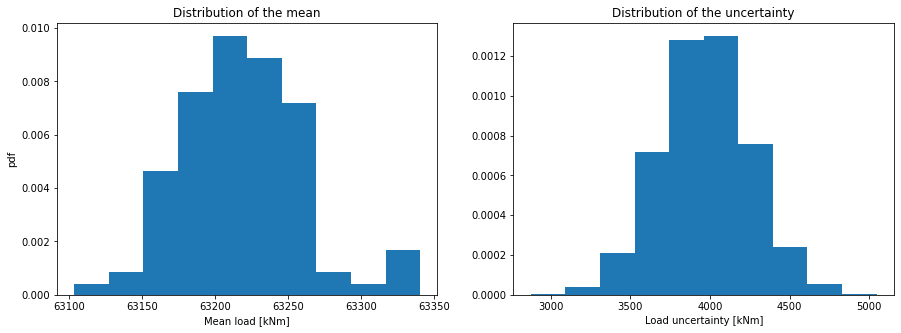

In [45]:
from sample import rosenblatt
from loads import MysteriousLoadFunc
import matplotlib.pyplot as plt
import numpy as np

nx = 10000
ny = 100

x = rosenblatt(nx)

y = np.zeros((nx, ny))
for i in range(ny):
    y[:, i] = MysteriousLoadFunc(x)

# How does the mean change over several executions?    
mean_y = np.mean(y, axis=0)
print(f'Uncertainty of mean:\t{np.std(mean_y):.0f}kNm = {np.std(mean_y)/mean_y.mean()*100:.2f}%')

# What is the unexplained variance?
var_y = np.var(y, axis=1).mean()
std_y = np.std(y, axis=1)
print(f'Unexplaind uncertainty:\t{std_y.mean():.0f}kNm = {std_y.mean()/mean_y.mean()*100:.2f}%')

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].hist(mean_y, density=True)
axs[0].set_title('Distribution of the mean')
axs[0].set_xlabel('Mean load [kNm]')
axs[0].set_ylabel('pdf')

axs[1].hist(std_y, density=True)
axs[1].set_title('Distribution of the uncertainty')
axs[1].set_xlabel('Load uncertainty [kNm]');


The first observation is that the fluctuations in the mean are negligible ($\approx 0.06\%$) which is good because it means that the statistics are stable. However, the second ovservation is that the unexplained deviation is very significant ($\approx 6\%$) and it is discussed later in the context of other uncertainties. Note that the law for the uncertainty of a mean is quite accurately observed $\sigma_{\mu_y} = \sigma_y/\sqrt{N}=\sigma_y/100$. 

## Explained Variance

In the next step, a model $f$ is trained to predict the loads from the input. By comparing the true to the predicted output the total error $\varepsilon$ captured.

$y = f(x) + \varepsilon = f(x) + \varepsilon_f - \varepsilon_y$

Subtracting $f(x)$ on both sides the errors are analyzed. Assuming there is no correlation between the true uncertainty $\varepsilon_y$ and the model uncertainty $\varepsilon_f$, which is very certain in this exercise, the explained variance of the model $Var[\varepsilon_f]$ is disseminated. 

$Var[\varepsilon] = Var[\varepsilon_f - \varepsilon_y]  = Var[\varepsilon_f] + Var[\varepsilon_y]$

To execute such an analysis in the following section, data is generated, a model is trained and its predictions are compared to the true values. 

In [62]:
import numpy as np
from procedure import model
from sample import rosenblatt

x = rosenblatt(10000)
y = MysteriousLoadFunc(x)

sol = model(x, y)

# Compare statistics of predicted and true data
E_pred = sol['y_pred'].mean()
E_true = sol['y_true'].mean()
print(f'Predicted expectation:    {E_pred:.0f}kNm')
print(f'True expectation:         {E_true:.0f}kNm')
print(f'Deviation:                {(E_pred-E_true)/E_true*100:.2f}%\n')

std_pred = np.std(sol['y_pred'])
std_true = np.std(sol['y_true'])
print(f'Predicted std. deviation: {std_pred:.0f}kNm')
print(f'True std. deviation:      {std_true:.0f}kNm')
print(f'Deviation:                {(std_pred-std_true)/std_true*100:.2f}%')

Predicted expectation:    63166kNm
True expectation:         63197kNm
Deviation:                -0%

Predicted std. deviation: 7684kNm
True std. deviation:      8173kNm
Deviation:                -6%


It is a good news that the expectations of the predictions and the true values match. But is still not a proof that the model is unbiased. It is remarkable that the the model fluctuates less than the true values. Therefore, not the whole variation is captured. Now, let's take a closer look on the uncertainties. 

### ToDo: The comparison of the expectations does not tell a lot. It is better to show the distribution of the errors. I think we did it somewhere. So we should restructure it. 

In [47]:
# total uncertainty (rms)
std = np.sqrt( np.sum( np.power(sol['y_pred'] - sol['y_true'], 2) ) / (sol['y_pred'].shape[0]-1) )
print(f'Total uncertainty:\t{std:.0f}kNm = {std/y.mean()*100:.2f}%')

# explained variance
var_f = std**2 - var_y
print(f'Explained variance:\t{var_f/u**2*100:.2f}%')

Total uncertainty:	4039kNm = 6.39%
Explained variance:	2.85%


To sum it up, there is total uncertainty of the model predictions to the true value of nearly 6.4%. Around 3% of this variance is explained by the model and accordingly 97% are based on the randomness of the true values i.e. not explainable by the model.

It is difficult to deliver a general assessment whether it is good or bad for the model to have a low uncertainty or a high variance. Because the true values inherently are stochastically distributed the deterministic model cannot capture its behavior. A compromise is necessary between an accurate model that minimizes the uncertainty and always delivers the expected value, and a model with a high variance that fluctuates in order to capture the spread of the true values. 

## Realization-to-realization uncertainty

By now, we have discussed the uncertainty in the MysteriousLoadFunc() but there is an uncertainty in the generation of the input data $x$ as well. Even if the distributions are the same the ensembles will differ. To analyze the effects several data sets are generated and each time a model is trained. Finally, the statistics are compared. 
### ToDo: Remove "print(f'Process: {(i+1)/N*100:.0f}%')" before publishing

In [63]:
from procedure import model

N = 25

sol = []
for i in range(N):
    x = rosenblatt(10000)
    y = MysteriousLoadFunc(x)
    s = model(x, y)
    sol.append(s)
    print(f'Process: {(i+1)/N*100:.0f}%')

Process: 4%
Process: 8%
Process: 12%
Process: 16%
Process: 20%
Process: 24%
Process: 28%
Process: 32%
Process: 36%
Process: 40%
Process: 44%
Process: 48%
Process: 52%
Process: 56%
Process: 60%
Process: 64%
Process: 68%
Process: 72%
Process: 76%
Process: 80%
Process: 84%
Process: 88%
Process: 92%
Process: 96%
Process: 100%


Mean: 4063kNm = 6.43%
Std:  98kNm = 0.16%
Min:  3912kNm = 6.19%
Max:  4388kNm = 6.94%


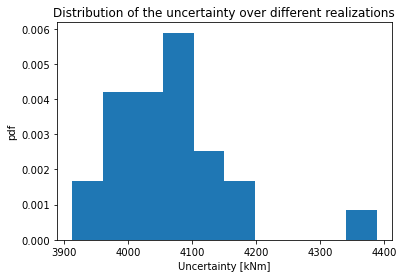

In [70]:
import matplotlib.pyplot as plt

u = np.array([sol[i]['u'] for i in range(N)])
E = np.mean([sol[i]['E'] for i in range(N)])

plt.figure()
plt.hist(u, density=True)
plt.xlabel('Uncertainty [kNm]')
plt.ylabel('pdf')
plt.title('Distribution of the uncertainty over different realizations')

print(f'Mean: {u.mean():.0f}kNm = {u.mean()/E*100:.2f}%')
print(f'Std:  {u.std():.0f}kNm = {u.std()/E*100:.2f}%')
print(f'Min:  {u.min():.0f}kNm = {u.min()/E*100:.2f}%')
print(f'Max:  {u.max():.0f}kNm = {u.max()/E*100:.2f}%')

The uncertainty fluctuates between 3900-4400kNm with a standard deviation of nearly 100kNm around the mean 4050kNm which is 6.4% of the expected load. The realization used in the sections before places itself right in the middle of this distribution. 